# このノートブックについて
Value At Riskを計算する練習用コードを収めています。
あなたの学習のお役に立ててください。

元エントリはこちらを参照してください。
http://recruit.gmo.jp/engineer/jisedai/blog/financial_technology_value_at_risk/

In [15]:
%matplotlib inline
import numpy as np
import matplotlib
import math
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from numpy.random import *
import pandas as pd



In [17]:
font_path = 'C:/Windows/Fonts/meiryo.ttc'
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()

fp = FontProperties( fname=font_path, size=14)


In [23]:
df = pd.read_csv("./usdjpy_2001_2017.csv")
df['date'] = pd.to_datetime(df['date'])

df = df[df['date'] < '2016-01-01']
# 差分を取る
df['diff'] = df['close'].diff(periods=1)

In [47]:
df['diff'] = df['diff'].fillna(0)
df['diff']

0       0.000
1       0.010
2      -0.710
3       1.860
4       0.990
5      -0.390
6       0.630
7      -0.480
8       1.560
9       0.630
10      0.410
11     -1.110
12      1.100
13     -0.850
14     -0.930
15     -0.620
16      0.150
17      1.170
18     -1.040
19      0.350
20     -0.450
21     -0.900
22      0.750
23     -0.900
24      0.020
25     -0.960
26     -0.010
27      1.550
28      0.500
29      0.760
        ...  
3871   -0.756
3872   -0.080
3873    0.036
3874   -0.292
3875    0.182
3876   -0.118
3877    0.118
3878    0.391
3879   -0.229
3880    0.364
3881   -0.637
3882    0.501
3883    0.267
3884   -0.439
3885   -1.489
3886    0.145
3887   -0.624
3888    0.040
3889    0.678
3890    0.517
3891    0.353
3892   -1.421
3893    0.040
3894   -0.105
3895   -0.156
3896   -0.585
3897    0.059
3898    0.067
3899    0.062
3900   -0.301
Name: diff, dtype: float64

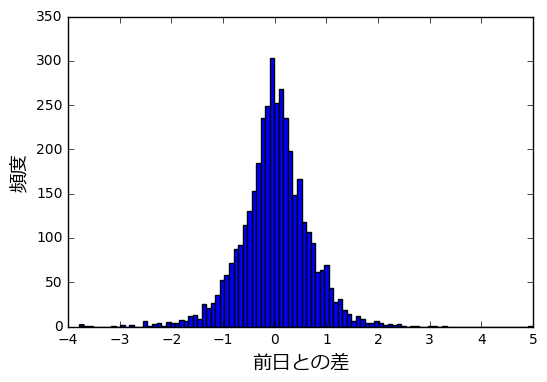

In [48]:
plt.figure()
df['diff'].plot.hist(bins=100)
plt.xlabel(u'前日との差',fontproperties=fp)
plt.ylabel(u'頻度',fontproperties=fp)


In [49]:
diff_sorted = df['diff'].sort_values(ascending=False)

In [50]:
len(diff_sorted.index)
type(diff_sorted)

pandas.core.series.Series

In [57]:
# 信頼水準99％のヒストリカル Value at Risk
pos_99 = int(len(diff_sorted.index)* 0.99)
pos_99

3861

In [52]:
diff_sorted.describe()

count    3901.000000
mean        0.001478
std         0.669069
min        -3.780000
25%        -0.346000
50%         0.000000
75%         0.370000
max         4.990000
Name: diff, dtype: float64

In [60]:
pos_99 = diff_sorted.index[3861]
diff_sorted[pos_99]

-1.8260000000000076

In [63]:
df['diff'].quantile(0.01)

-1.8260000000000076

In [66]:
df['diff'].std()*2.33

1.5589315776836383

In [69]:
df['diff'].mean()

0.0014783388874647515

In [70]:
# ゴールド価格の読み込み
df_gold = pd.read_csv("./xau_usd_2001_2017.csv")
df_gold['date'] = pd.to_datetime(df_gold['date'])

df_gold = df_gold[df_gold['date'] < '2016-01-01']
# 差分を取る
df_gold['diff'] = df_gold['close'].diff(periods=1)

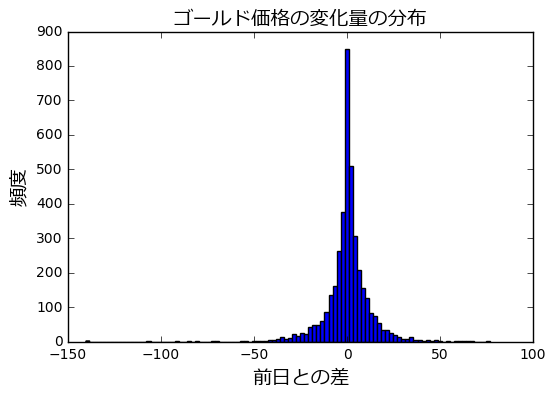

In [71]:
plt.figure()
df_gold['diff'].plot.hist(bins=100)
plt.xlabel(u'前日との差',fontproperties=fp)
plt.ylabel(u'頻度',fontproperties=fp)
plt.title(u'ゴールド価格の変化量の分布',fontproperties=fp)

In [110]:
# ドル円相場データの読み込み
df_usdjpy = pd.read_csv("./usdjpy_2001_2017.csv")
df_usdjpy['date'] = pd.to_datetime(df_usdjpy['date'])

# 2015年1月～12月の範囲を取り出す
df_usdjpy = df_usdjpy[(df_usdjpy['date'] < '2016-01-01') & (df_usdjpy['date'] > '2015-01-01')]

# ゴールド価格の読み込み
df_gold = pd.read_csv("./xau_usd_2001_2017.csv")
df_gold['date'] = pd.to_datetime(df_gold['date'])

# 2015年1月～12月の範囲を取り出す
df_gold = df_gold[(df_gold['date'] < '2016-01-01') & (df_gold['date'] > '2015-01-01')]

df_usdjpy = df_usdjpy.set_index('date')
df_gold = df_gold.set_index('date')

In [136]:
# 最初の日の相場を取り出す
first_index = df_usdjpy.index[0]

first_usdjpy = df_usdjpy.ix[first_index]
first_gold = df_gold.ix[first_index]

# 保有資産はそれぞれ100億円分でスタート
start_value = 100 * 100000000

# 初日の終値から購入量を計算する
# 100億円 ÷ 終値 = 資産購入量
amount_usd  = start_value * 1.0 / first_usdjpy['close']
amount_gold = start_value * 1.0 / ( first_gold['close'] * first_usdjpy['close'] )

print "ドル購入量(100億円分) = %s ドル" % (amount_usd)
print "ゴールド購入量(100億円分) = %s オンス" % (amount_gold)


ドル購入量(100億円分) = 83043373.554 ドル
ゴールド購入量(100億円分) = 70856.1207799 オンス


In [128]:
# ポートフォリオ価値の推移を記録する。
# date      : 日付
# pf_value  : 円換算時のポートフォリオ価値
# usdjpy    : ドル円価格
# gold_usd  : 金価格(ドル換算)
# gold_jpy  : 金価格(円換算)
pf_history = pd.DataFrame(columns=['date','pf_value','usdjpy','gold_usd','gold_jpy'])
for index_cursor in df_usdjpy.index:
    # 各日付におけるポートフォリオ価値の計算
    each_pf_value = amount_usd * df_usdjpy['close'][index_cursor] + \
                    amount_gold * df_usdjpy['close'][index_cursor] * df_gold['close'][index_cursor]
    
    print "%s  pf_value=%s" % (index_cursor,each_pf_value)
    # ポートフォリオ価値の推移を記録する
    pf_history = pf_history.append( pd.DataFrame([[index_cursor,each_pf_value,df_usdjpy['close'][index_cursor],df_gold['close'][index_cursor],
                                     df_usdjpy['close'][index_cursor] * df_gold['close'][index_cursor]]],
                                    columns=['date','pf_value','usdjpy','gold_usd','gold_jpy']))

2015-01-02 00:00:00  pf_value=20000000000.0
2015-01-05 00:00:00  pf_value=20105627770.1
2015-01-06 00:00:00  pf_value=19967415466.6
2015-01-07 00:00:00  pf_value=20129634567.8
2015-01-08 00:00:00  pf_value=20235825218.9
2015-01-09 00:00:00  pf_value=20044839793.9
2015-01-12 00:00:00  pf_value=20111524381.0
2015-01-13 00:00:00  pf_value=20082263070.5
2015-01-14 00:00:00  pf_value=20008494444.3
2015-01-15 00:00:00  pf_value=20006463566.2
2015-01-16 00:00:00  pf_value=20413329048.1
2015-01-19 00:00:00  pf_value=20369670269.9
2015-01-20 00:00:00  pf_value=20712898849.5
2015-01-21 00:00:00  pf_value=20605016182.5
2015-01-22 00:00:00  pf_value=20714640025.3
2015-01-23 00:00:00  pf_value=20578301327.7
2015-01-26 00:00:00  pf_value=20589624660.1
2015-01-27 00:00:00  pf_value=20548236126.2
2015-01-28 00:00:00  pf_value=20484622138.6
2015-01-29 00:00:00  pf_value=20453932538.8
2015-01-30 00:00:00  pf_value=20245172452.0
2015-02-02 00:00:00  pf_value=20365944832.2
2015-02-03 00:00:00  pf_value=20

In [129]:
# 各資産価格の変化量の計算
pf_history['diff_usdjpy'] = pf_history['usdjpy'].diff(periods=1)
pf_history['diff_gold_usd'] = pf_history['gold_usd'].diff(periods=1)
pf_history['diff_gold_jpy'] = pf_history['gold_jpy'].diff(periods=1)


In [137]:
print "[USDJPY] 平均:%s    標準偏差(σ):%s" % ( pf_history['diff_usdjpy'].mean(),pf_history['diff_usdjpy'].std())
print "[ゴールド] 平均:%s    標準偏差(σ):%s" % ( pf_history['diff_gold_usd'].mean(),pf_history['diff_gold_usd'].std())
print "[ゴールド(円換算)] 平均:%s    標準偏差(σ):%s" % ( pf_history['diff_gold_jpy'].mean(),pf_history['diff_gold_jpy'].std())


[USDJPY] 平均:-0.000821705426357    標準偏差(σ):0.621896383698
[ゴールド] 平均:-0.434108527132    標準偏差(σ):10.1231867464
[ゴールド(円換算)] 平均:-53.1459224806    標準偏差(σ):1203.38599955


In [281]:
# ポートフォリオ全体の資産価格の変化量の計算
pf_history['diff_pf_value'] = pf_history['pf_value'].diff(periods=1)
print "[ポートフォリオ全体] 平均:%s    標準偏差(σ):%s" % ( pf_history['diff_pf_value'].mean(),pf_history['diff_pf_value'].std())
print pf_history['diff_pf_value'].mean() - 2.33 * pf_history['diff_pf_value'].std()

[ポートフォリオ全体] 平均:-3833951.09292    標準偏差(σ):111043617.681
-262565580.289


In [272]:
pf_history['diff_pf_value'] = pf_history['diff_pf_value'].fillna(0)
pf_history['diff_pf_value'].quantile(1.0-0.99)

-259951119.62165439

In [154]:
amount_gold

70856.120779869671

In [162]:
df_cov = pd.DataFrame(columns=["usdjpy","gold_jpy"])
df_cov['usdjpy'] = pf_history["usdjpy"] * amount_usd
df_cov['gold_jpy'] = pf_history["gold_jpy"] * amount_gold

In [163]:
df_cov['usdjpy'] = df_cov['usdjpy'].diff(periods=1).fillna(0)
df_cov['gold_jpy'] = df_cov['gold_jpy'].diff(periods=1).fillna(0)


In [164]:
cov_matrix = df_cov.cov()
print cov_matrix

                usdjpy      gold_jpy
usdjpy    2.656804e+15  1.191882e+15
gold_jpy  1.191882e+15  7.242381e+15



$ σ_{portfolio} =\sqrt{  \left(
\begin{array}{ccc}
Δ_{usdjpy} & Δ_{goldjpy} 
\end{array}
\right) 
\left(
\begin{array}{ccc}
V_{usdjpy} & V_{usdjpy,goldjpy} \\
V_{usdjpy,goldjpy} & V_{goldjpy}
\end{array}
\right)
\left(
\begin{array}{ccc}
Δ_{usdjpy} \\
Δ_{goldjpy} 
\end{array}
\right)
}
$


$
σ_{portfolio} : ポートフォリオ全体の標準偏差 \\
Δ_{usdjpy} : ドル円の感応度。1.0 とする。\\
Δ_{goldjpy} : ドル円の感応度。1.0 とする。\\
V_{usdjpy} : ドル円資産の標準偏差\\
V_{goldjpy} : ゴールド資産(円換算)の標準偏差\\
V_{usdjpy,goldjpy} : ドル円資産とゴールド資産（円換算）の共分散
$


In [165]:
delta = np.array([1,1])

In [167]:
np.sqrt(np.dot( np.dot(delta,cov_matrix),delta.T)) * 2.33


258230321.07620987

# モンテカルロシミュレーション法
## 1.リスクファクターの振る舞いを調べる

[平均値] -53.1459224806    [標準偏差] 1203.38599955


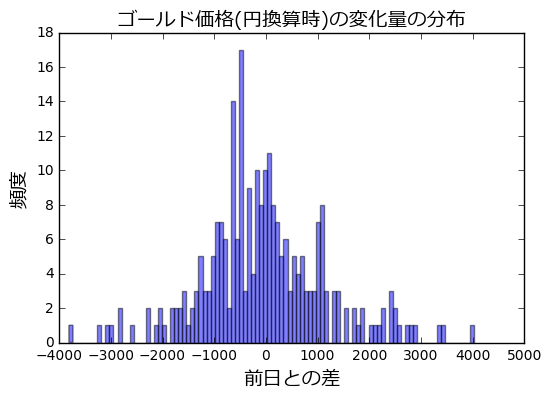

In [172]:
pf_history['diff_gold_jpy'].plot(kind='hist',bins=100,alpha=0.5)
plt.xlabel(u'前日との差',fontproperties=fp)
plt.ylabel(u'頻度',fontproperties=fp)
plt.title(u'ゴールド価格(円換算時)の変化量の分布',fontproperties=fp)
print "[平均値] %s    [標準偏差] %s" % (pf_history['diff_gold_jpy'].mean(),pf_history['diff_gold_jpy'].std() )

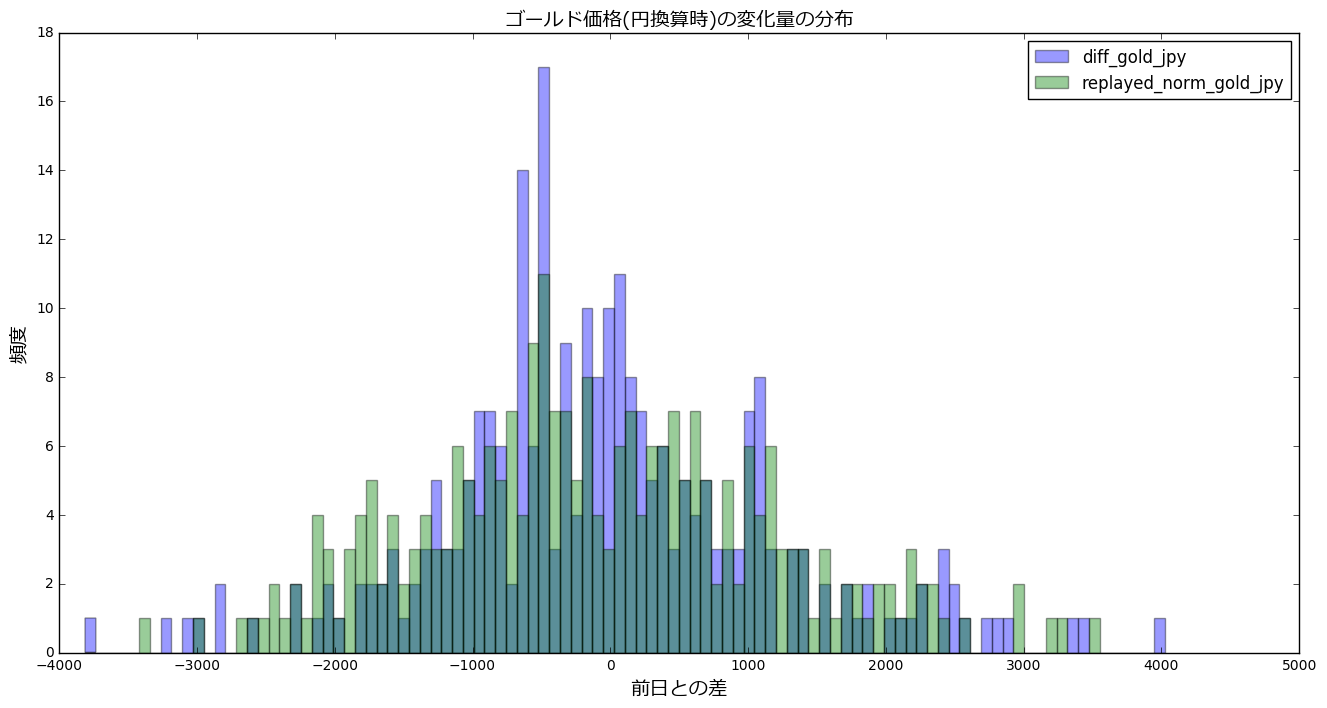

In [189]:
from numpy.random import *
# 正規分布かどうか調べる
avg_dist = pf_history['diff_gold_jpy'].mean()
std_dist = pf_history['diff_gold_jpy'].std() 
pf_history['replayed_norm_gold_jpy'] = normal(avg_dist,std_dist,len(pf_history.index))
    
pf_history.plot(y=['diff_gold_jpy','replayed_norm_gold_jpy'],kind='hist',bins=100,alpha=0.4,figsize=(16,8))
plt.xlabel(u'前日との差',fontproperties=fp)
plt.ylabel(u'頻度',fontproperties=fp)
plt.title(u'ゴールド価格(円換算時)の変化量の分布',fontproperties=fp)


In [204]:
print "[ドル円の統計情報]"
avg_usdjpy = pf_history['diff_usdjpy'].mean()
std_usdjpy = pf_history['diff_usdjpy'].std()
print "平均値:%s    標準偏差:%s" % (avg_usdjpy,std_usdjpy)

print "[ゴールド(円換算)の統計情報]"
avg_goldjpy = pf_history['diff_gold_jpy'].mean()
std_goldjpy = pf_history['diff_gold_jpy'].std()
print "平均値:%s    標準偏差:%s" % (avg_goldjpy,std_goldjpy)


[ドル円の統計情報]
平均値:-0.000821705426357    標準偏差:0.621896383698
[ゴールド(円換算)の統計情報]
平均値:-53.1459224806    標準偏差:1203.38599955


In [202]:
# 最初の日の相場を取り出す
first_index = df_usdjpy.index[0]

first_usdjpy = df_usdjpy.ix[first_index]
first_gold = df_gold.ix[first_index]

# 保有資産はそれぞれ100億円分でスタート
start_value = 100 * 100000000

# 初日の終値から購入量を計算する
# 100億円 ÷ 終値 = 資産購入量
amount_usd  = start_value * 1.0 / first_usdjpy['close']
amount_gold = start_value * 1.0 / ( first_gold['close'] * first_usdjpy['close'] )

first_value_usdjpy = first_usdjpy['close']
first_value_goldjpy = first_gold['close'] * first_usdjpy['close']

print "[ドル円初期値] %s" % (first_value_usdjpy)
print "[ゴールド価格(円換算)初期値] %s" % (first_value_goldjpy)
print "ドル購入量(100億円分) = %s ドル" % (amount_usd)
print "ゴールド購入量(100億円分) = %s オンス" % (amount_gold)


[ドル円初期値] 120.419
[ゴールド価格(円換算)初期値] 141131.068
ドル購入量(100億円分) = 83043373.554 ドル
ゴールド購入量(100億円分) = 70856.1207799 オンス


In [276]:
# モンテカルロシミュレーションで求めたポートフォリオ価格の推移を記録する
mc_pf_history = []

# シミュレーション回数
simulate_count = 1000
for sim_count in range(simulate_count):
    print "[simulation] epoch %d" % (sim_count)
    
    # 各シミュレーションごとのパラメータ初期化
    value_usdjpy = first_value_usdjpy
    value_goldjpy = first_value_goldjpy
    pf_value_last  = start_value * 2    
    for pos in range(len(df_usdjpy.index)):
        pf_value = value_usdjpy * amount_usd + value_goldjpy * amount_gold
        diff_pf_value = pf_value - pf_value_last
        mc_pf_history.append(diff_pf_value)
        pf_value_last = pf_value 
        #print "[portfolio value] %s" % (pf_value)
        value_usdjpy += normal(avg_usdjpy,std_usdjpy)
        value_goldjpy += normal(avg_goldjpy,std_goldjpy)

        

[simulation] epoch 0
[simulation] epoch 1
[simulation] epoch 2
[simulation] epoch 3
[simulation] epoch 4
[simulation] epoch 5
[simulation] epoch 6
[simulation] epoch 7
[simulation] epoch 8
[simulation] epoch 9
[simulation] epoch 10
[simulation] epoch 11
[simulation] epoch 12
[simulation] epoch 13
[simulation] epoch 14
[simulation] epoch 15
[simulation] epoch 16
[simulation] epoch 17
[simulation] epoch 18
[simulation] epoch 19
[simulation] epoch 20
[simulation] epoch 21
[simulation] epoch 22
[simulation] epoch 23
[simulation] epoch 24
[simulation] epoch 25
[simulation] epoch 26
[simulation] epoch 27
[simulation] epoch 28
[simulation] epoch 29
[simulation] epoch 30
[simulation] epoch 31
[simulation] epoch 32
[simulation] epoch 33
[simulation] epoch 34
[simulation] epoch 35
[simulation] epoch 36
[simulation] epoch 37
[simulation] epoch 38
[simulation] epoch 39
[simulation] epoch 40
[simulation] epoch 41
[simulation] epoch 42
[simulation] epoch 43
[simulation] epoch 44
[simulation] epoch 4

In [277]:
df_mc_history = pd.DataFrame(mc_pf_history,columns=["diff_pf_value"])

In [278]:
print df_mc_history.sort(["diff_pf_value"])

        diff_pf_value
14160   -4.607514e+08
158823  -4.248351e+08
112553  -4.112933e+08
25154   -4.068834e+08
26553   -4.020113e+08
202769  -4.009543e+08
254263  -3.957812e+08
45809   -3.935194e+08
129473  -3.890166e+08
62350   -3.890036e+08
157408  -3.883010e+08
53065   -3.880042e+08
206656  -3.877152e+08
100674  -3.873868e+08
8598    -3.870600e+08
154016  -3.833903e+08
238599  -3.806109e+08
128450  -3.791088e+08
243002  -3.768539e+08
135176  -3.768072e+08
157628  -3.767736e+08
130544  -3.754477e+08
77362   -3.752378e+08
38395   -3.751507e+08
80555   -3.682774e+08
169519  -3.676002e+08
127727  -3.648092e+08
51184   -3.647265e+08
241570  -3.640462e+08
193503  -3.634042e+08
...               ...
250628   3.564627e+08
210278   3.592740e+08
81693    3.595171e+08
55185    3.606302e+08
28297    3.613995e+08
231105   3.614946e+08
107043   3.624900e+08
161217   3.645430e+08
77691    3.672307e+08
81456    3.681510e+08
20143    3.688056e+08
61723    3.693560e+08
211126   3.715453e+08
142528   3

C:\Program Files\Anaconda3\envs\python27\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [282]:
print "[標準偏差:モンテカルロシミュレーション法]\n %s" % (df_mc_history["diff_pf_value"].std())
print "[平均値:モンテカルロシミュレーション法]\n %s" % (df_mc_history["diff_pf_value"].mean())
print "[Value at Risk:モンテカルロシミュレーション法]\n %s" % (df_mc_history["diff_pf_value"].std()*2.33)
print df_mc_history["diff_pf_value"].quantile(1.0-0.99)

[標準偏差:モンテカルロシミュレーション法]
 99621110.9981
[平均値:モンテカルロシミュレーション法]
 -3711422.06767
[Value at Risk:モンテカルロシミュレーション法]
 232117188.625
-235840670.696


In [280]:
# モンテカルロシミュレーションで再現したリスクファクターの値（ドル円＆ゴールド価格）の相関を調べる
df_mc_factor = pd.DataFrame(columns=["usdjpy","goldjpy"])

# シミュレーション回数
simulate_count = 1

factor_usdjpy = []
factor_goldjpy = []
for sim_count in range(simulate_count):
    # 各シミュレーションごとのパラメータ初期化
    value_usdjpy = first_value_usdjpy
    value_goldjpy = first_value_goldjpy
    for pos in range(len(df_usdjpy.index)):
        # 通常配列に追加するほうが、データフレームとして追加するよりずっと速い
        factor_usdjpy.append(value_usdjpy)
        factor_goldjpy.append(value_goldjpy)
        value_usdjpy += normal(avg_usdjpy,std_usdjpy)
        value_goldjpy += normal(avg_goldjpy,std_goldjpy)

df_mc_factor['usdjpy'] = factor_usdjpy
df_mc_factor['goldjpy'] = factor_goldjpy

In [270]:
print df_mc_factor

         usdjpy        goldjpy
0    120.419000  141131.068000
1    120.679882  143312.639138
2    119.705157  142672.603176
3    119.455714  141525.746536
4    119.802514  144125.974910
5    120.277908  144929.291555
6    120.133549  146257.854444
7    119.155719  146400.335874
8    119.006446  147332.374403
9    119.277005  145735.998440
10   119.475216  142242.758476
11   119.490194  141784.875241
12   119.401230  142034.728699
13   118.477028  142031.880100
14   118.279881  142076.977625
15   118.071321  143902.732765
16   118.838652  142564.745708
17   118.454638  142089.679012
18   118.572586  141382.831757
19   118.841963  139027.782976
20   117.834910  139954.217081
21   117.108609  139576.683954
22   116.389875  138728.273086
23   116.128507  140976.900040
24   115.776195  141705.083176
25   115.445727  141053.731212
26   115.464580  140560.653256
27   116.060317  138207.958446
28   115.758153  138762.466835
29   115.536356  138363.258689
..          ...            ...
229  108

In [271]:
print df_mc_factor.corr()

           usdjpy   goldjpy
usdjpy   1.000000  0.090648
goldjpy  0.090648  1.000000
